<a href="https://colab.research.google.com/github/Envivi-git/Nomenaments/blob/main/Nomenaments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries, getting data, basic data cleanning

## Importing libraries

In [ ]:
import os
import sys

os.path.dirname(sys.executable)

'C:\\Users\\Usuario\\AppData\\Local\\Programs\\Python\\Python38'

C:\Users\Usuario\AppData\Local\Programs\Python\Python38\Lib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from unicodedata import normalize
import pickle
import sqlite3
import sqlalchemy
from datetime import date
import time
from tqdm import tqdm
import re
import json
from unidecode import  unidecode
from urllib.parse import unquote
import googlemaps


In [ ]:
import requests
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as bs

## Functions

In [ ]:
def convert_to_pandas_df(table_html:list):
  '''
  The function take a list which contains a table read from a html page and transform it into pandas dataFrame
  '''

  table_html=table_html[0]
  header=table_html.iloc[0,:].to_list()
  df=table_html.iloc[1:,:]
  df.columns=header

  return df


In [ ]:
def transform_data_type(df_input):
  '''
  The function return the data with the proper data types
  '''
  df_output=df_input.copy()
  df_output[['data','inici','fi']]=df_input[['data','inici','fi']].apply(pd.to_datetime)
  df_output[['n','jor']]=df_input[['n','jor']].apply(pd.to_numeric)
  df_output['jornada']=df_output['jor'].apply(lambda x: x if x==1 else (x/100 if x>10 else x/10))
  df_output.drop(['jor'], axis=1, inplace=True)
  df_output['st']=df_input['st'].apply(pd.to_numeric)
  df_output['centre']= df_input['centre'].apply(lambda x: str(x))
  df_output['k']= df_input['k'].apply(lambda x: str(x))
  df_output['proc']= df_input['proc'].apply(lambda x: str(x))

  return df_output



## Reading data source

In [ ]:
url="https://antiga.sindicat.net/nomenaments/avui/"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:80.0) Gecko/20100101 Firefox/80.0'}
page = requests.get(url, headers=headers)
contenido = bs(page.content)

In [ ]:
#getting data
links=contenido.find("div", attrs={"id":"apDiv1"}).find_all("a")

In [ ]:
links_dict = {}

for i in tqdm(links):
  k = i.string
  v = i["href"]
  links_dict[k]=v

last_data={links[0].string:links[0]["href"]}

100%|██████████| 63/63 [00:00<?, ?it/s]


### Getting all the data

In [ ]:
for k,v in tqdm(links_dict.items()):
  links_dict[k]=[v,pd.read_html(v,encoding="UTF-8")]

100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


### Getting data from the last day

In [ ]:
k = list(last_data.keys())[0]
last_data[k] = [last_data[k], pd.read_html(last_data[k],encoding="UTF-8")]

### Visualize some data

In [ ]:
ascending_days = list(links_dict.keys())[::-1]
df = convert_to_pandas_df(links_dict[ascending_days[0]][1])
df.head()

,st,data,n,centre,jor,inici,fi,k,proc
1,1,22/07/2021,2220,EOI Barcelona IV,05,01/09/2021,31/08/2022,133,ae
2,1,22/07/2021,28706,EOI Barcelona-Vall d'Hebron,1,01/09/2021,31/08/2022,133,ae
3,1,22/07/2021,456,EOI Barcelona-Vall d'Hebron,1,01/09/2021,31/08/2022,133,ae
4,1,22/07/2021,8019,EOI de Barcelona,1,01/09/2021,31/08/2022,133,ae
5,1,22/07/2021,6707,EOI de Barcelona,1,01/09/2021,31/08/2022,133,ae


#### st = servei territorial

In [ ]:
st_dict={1:'Barcelona Consorci',2:'Barcelona Comarques', 3:"Baix Llobregat",4:"Vallès Occidental", 5:"Maresme Vallès Or",6:"6 Catalunya Central",
       17:"Girona",25:" Lleida",43:"Tarragona",44:"Terres de l'Ebre"}

df_st = pd.DataFrame.from_dict(st_dict,orient="index",columns=['st']).reset_index()
df_st.columns=['key','servei_territorial']
df_st


,key,servei_territorial
0,1,Barcelona Consorci
1,2,Barcelona Comarques
2,3,Baix Llobregat
3,4,Vallès Occidental
4,5,Maresme Vallès Or
5,6,6 Catalunya Central
6,17,Girona
7,25,Lleida
8,43,Tarragona
9,44,Terres de l'Ebre


#### k = procediment

In [ ]:
dict_k={'nt': 'nomenament telemàtic','dif': 'adjudicacions de difícil cobertura','urg': "adjudicacions de procediment d'urgència",
        "dir": "selecció per part dels directors" }
df_k = pd.DataFrame.from_dict(dict_k,orient="index",columns=['procediment']).reset_index()
df_k.columns=['key','procediment']
df_k

,key,procediment
0,nt,nomenament telemàtic
1,dif,adjudicacions de difícil cobertura
2,urg,adjudicacions de procediment d'urgència
3,dir,selecció per part dels directors


## Data selection

I am interested to know what happens at the first 15 “Nomenaments”. All the people selected in this time window will be working the whole year.

In addition, I will also store all the data.

In [ ]:
# 15 first Nomenaments
data = [convert_to_pandas_df(links_dict[i][1]) for i in ascending_days[:15]]

#All data
data_complete = [convert_to_pandas_df(links_dict[i][1]) for i in ascending_days]


In [ ]:
with open('data_to_inici.pickle', 'wb') as handle:
    pickle.dump(data_complete, handle)

In [ ]:
df_inici_nomenament=pd.merge(df_inici,df_st, how="left", on='st')

In [ ]:
df_inici_nomenament.to_csv('data_nomenaments_inici.csv')

## Data cleasing

### Looking for duplicates

In [ ]:
print([i.duplicated().sum() for i in data])
print([i.duplicated().sum() for i in data_complete])

[0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
#Drop dulicated data
for j in [i.duplicated().sum() for i in data_complete]:
    if j !=0:
        data_complete[j] = data_complete[j].drop_duplicates(keep=False)

### checking for bad date formats

In [ ]:
n=0
for df in tqdm(data_complete):
    df=df[['data','inici','fi']]
    for index_ in range(len(df)):
        try:
            df.iloc[index_].apply(pd.to_datetime)
        except:
            print(n,index_)

    n= n+1

  6%|▋         | 4/63 [00:21<03:48,  3.87s/it]

4 46


 32%|███▏      | 20/63 [00:26<00:13,  3.20it/s]

20 23


 68%|██████▊   | 43/63 [00:29<00:02,  7.84it/s]

42 107


 75%|███████▍  | 47/63 [00:29<00:01,  8.66it/s]

47 15


100%|██████████| 63/63 [00:32<00:00,  1.96it/s]

62 0


Checking the formats individually and correcting data

#### case 1

In [ ]:
data_complete[4][['data','inici','fi']].iloc[46]


data      02/09/2021
inici     02/09/2021
fi       30/06/22022
Name: 47, dtype: object

In [ ]:
data_complete[4].at[47,'fi'] ='30/06/2022'

In [ ]:
data_complete[4][['data','inici','fi']].iloc[46]

data     02/09/2021
inici    02/09/2021
fi       30/06/2022
Name: 47, dtype: object

#### case 2

In [ ]:
data_complete[20][['data','inici','fi']].iloc[23]

data     23/09/2021
inici    23/09/2021
fi       01.11.21 I
Name: 24, dtype: object

In [ ]:
data_complete[20].at[24,'fi'] ='01/11/2021'

In [ ]:
data_complete[20][['data','inici','fi']].iloc[23]

data     23/09/2021
inici    23/09/2021
fi       01/11/2021
Name: 24, dtype: object

#### case 3

In [ ]:
data_complete[42][['data','inici','fi']].iloc[107]

data     25/10/2021
inici    25/10/2021
fi        22/102021
Name: 108, dtype: object

In [ ]:
data_complete[42].at[108,'fi'] ='22/10/2021'

In [ ]:
data_complete[42][['data','inici','fi']].iloc[107]

data     25/10/2021
inici    25/10/2021
fi       22/10/2021
Name: 108, dtype: object

#### case 4

In [ ]:
data_complete[47][['data','inici','fi']].iloc[15]

data      02/11/2021
inici     02/11/2021
fi       18/11/20211
Name: 16, dtype: object

In [ ]:
data_complete[47].at[16,'fi'] ='18/11/2021'

In [ ]:
data_complete[47][['data','inici','fi']].iloc[15]

data     02/11/2021
inici    02/11/2021
fi       18/11/2021
Name: 16, dtype: object

#### case 5

In [ ]:
data_complete[62][['data','inici','fi']].iloc[0]

data            17/12/2021
inici           17/12/2021
fi       Camps Gámez,Roger
Name: 1, dtype: object

In [ ]:
#This case its marked by given a fi lower than inici. 
# Therefore, when time interval is calculated, the data point will be rejected because will be giving a negative time interval
data_complete[62].at[1,'fi'] ='17/12/2020'

In [ ]:
data_complete[62][['data','inici','fi']].iloc[0]

data     17/12/2021
inici    17/12/2021
fi       17/12/2020
Name: 1, dtype: object

### Transform data types

In [ ]:
data=[transform_data_type(i) for i in data]
data_complete=[transform_data_type(i) for i in data_complete]

In [ ]:
data[0].head()

,st,data,n,centre,inici,fi,k,proc,jornada
1,1,2021-07-22,2220,EOI Barcelona IV,2021-01-09,2022-08-31,133,ae,0.5
2,1,2021-07-22,28706,EOI Barcelona-Vall d'Hebron,2021-01-09,2022-08-31,133,ae,1.0
3,1,2021-07-22,456,EOI Barcelona-Vall d'Hebron,2021-01-09,2022-08-31,133,ae,1.0
4,1,2021-07-22,8019,EOI de Barcelona,2021-01-09,2022-08-31,133,ae,1.0
5,1,2021-07-22,6707,EOI de Barcelona,2021-01-09,2022-08-31,133,ae,1.0


In [ ]:
with open('data_inici_clean.pickle', 'wb') as handle:
    pickle.dump(data, handle)

In [ ]:
with open('data_complete_clean.pickle', 'wb') as handle:
    pickle.dump(data_complete, handle)

In [ ]:
data_complete=pd.read_pickle('data_complete_clean.pickle')

In [ ]:
data_complete = pd.concat(data_complete)

In [ ]:
data_complete.head()

,st,data,n,centre,inici,fi,k,proc,jornada
1,1,2021-07-22,2220,EOI Barcelona IV,2021-01-09,2022-08-31,133,ae,0.5
2,1,2021-07-22,28706,EOI Barcelona-Vall d'Hebron,2021-01-09,2022-08-31,133,ae,1.0
3,1,2021-07-22,456,EOI Barcelona-Vall d'Hebron,2021-01-09,2022-08-31,133,ae,1.0
4,1,2021-07-22,8019,EOI de Barcelona,2021-01-09,2022-08-31,133,ae,1.0
5,1,2021-07-22,6707,EOI de Barcelona,2021-01-09,2022-08-31,133,ae,1.0


# Data analysis

***Question:*** ¿Is it possible to work on the period labeled as ***inici***?

## Concatenate all dataframes, cooresponding to the initial period and keep values of n with the highest "inici"

In [ ]:
df_inici = pd.concat(data, axis=0).reset_index(drop=True)
df_inici.head()

,st,data,n,centre,inici,fi,k,proc,jornada
0,1,2021-07-22,2220,EOI Barcelona IV,2021-01-09,2022-08-31,133,ae,0.5
1,1,2021-07-22,28706,EOI Barcelona-Vall d'Hebron,2021-01-09,2022-08-31,133,ae,1.0
2,1,2021-07-22,456,EOI Barcelona-Vall d'Hebron,2021-01-09,2022-08-31,133,ae,1.0
3,1,2021-07-22,8019,EOI de Barcelona,2021-01-09,2022-08-31,133,ae,1.0
4,1,2021-07-22,6707,EOI de Barcelona,2021-01-09,2022-08-31,133,ae,1.0


In [ ]:
df_inici=df_inici.sort_values(['n', 'inici'], ascending=[True, True]).reset_index(drop=True)
df_inici.head()

,st,data,n,centre,inici,fi,k,proc,jornada
0,43,2021-07-22,1,Institut Marta Mata,2021-01-09,2022-08-31,GE,ae,1.0
1,17,2021-01-09,2,Institut - Jaume Vicens Vives (Girona),2021-02-09,2021-01-11,PSI,nt,1.0
2,4,2021-08-26,3,Institut - Can Jofresa (Terrassa),2021-01-09,2022-08-31,DI,nt,1.0
3,2,2021-07-22,5,Institut Pedraforca,2021-01-09,2022-08-31,LE,ae,1.0
4,1,2021-07-22,6,Institut Pablo R. Picasso,2021-01-09,2022-08-31,GE,ae,1.0


In [ ]:
#compruebo longitud
len(df_inici)==sum([len(i) for i in data])

True

In [ ]:
#keep the last date
df_inici=df_inici.drop_duplicates(subset=['n'], keep='last')

In [ ]:
with open('data_concat_inici_filt.pickle', 'wb') as handle:
    pickle.dump(df_inici, handle)

In [ ]:
df_inici=pd.read_pickle('data_concat_inici_filt.pickle')

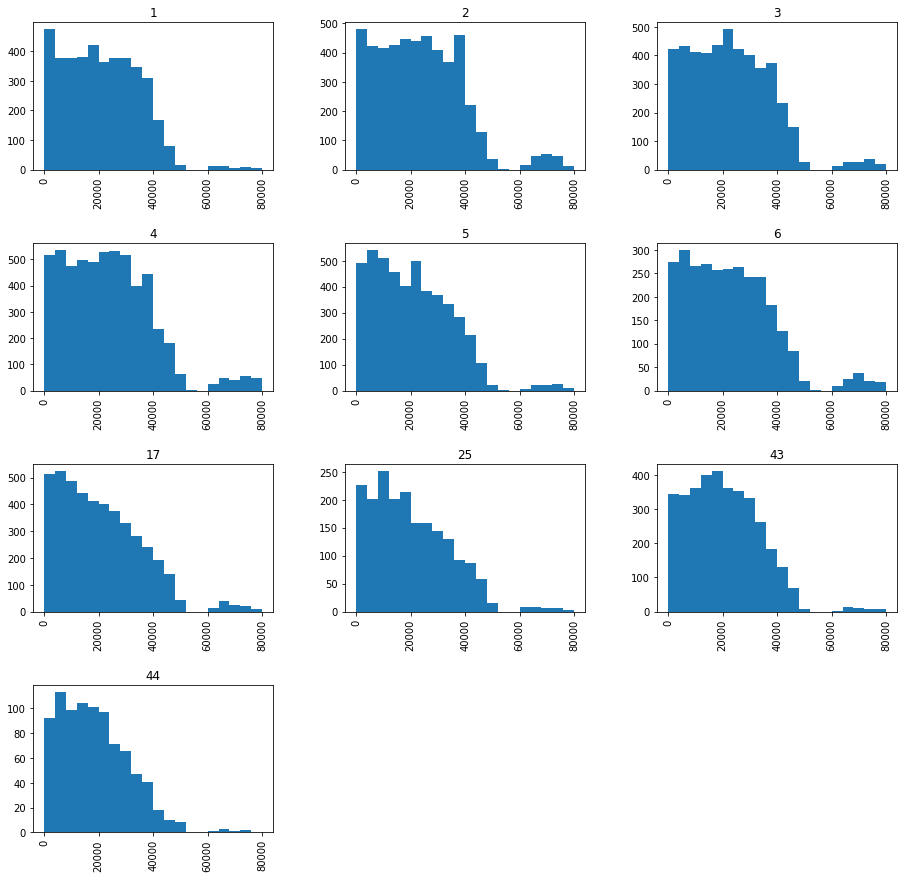

In [ ]:
df_inici['n'].hist(by=df_inici['st'],figsize=(15,15),bins=20,range=[0, 80_000])
plt.xlim(0, 50)
plt.show()

### Preliminar conclusions

* Is it possible to distinguish between two different areas; one roughtly constant another one is decreasing.
* Constants area may be attributed to all the available people with a certain number being working.
* Decreasing area may be attributed to a people being call upon particular conditions and specific cases.

## Repeat analysis for all available datasets

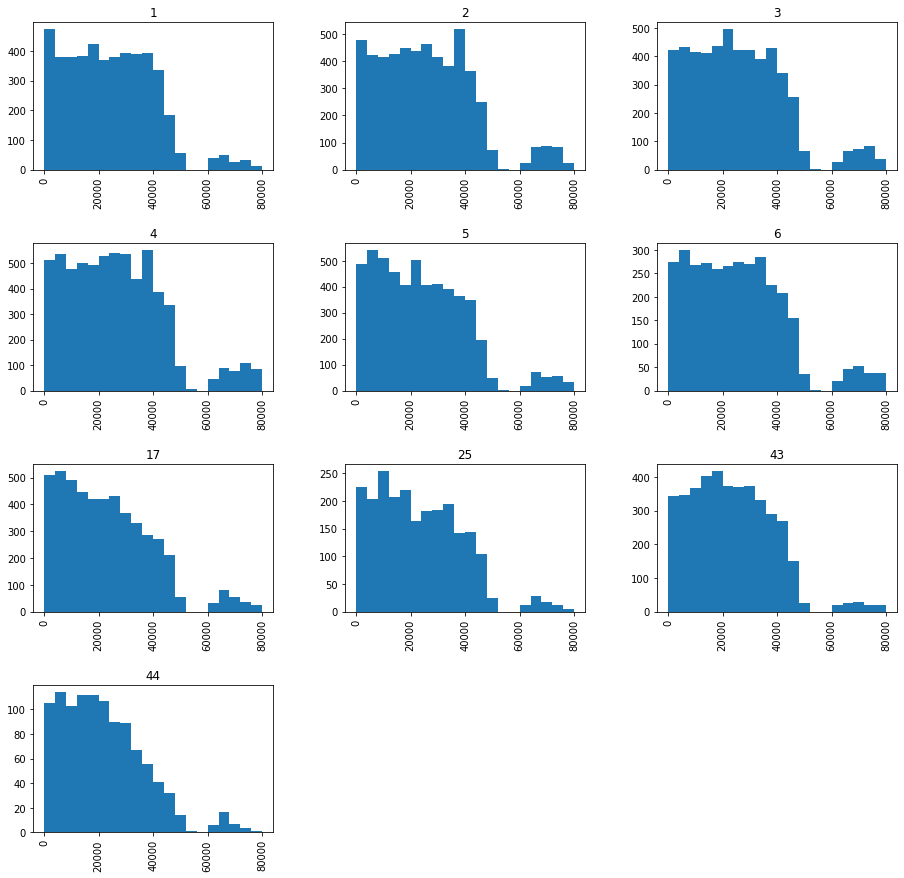

In [ ]:
df_total = pd.concat(data_complete, axis=0).reset_index(drop=True)
df_total=df_total.sort_values(['n', 'inici'], ascending=[True, True]).reset_index(drop=True)
# It is not possible to use the fi date as comparasion to know if a person is currently working or not.
# Because subtitution can be elongated and it is only comunicated to the affected person
df_total=df_total.drop_duplicates(subset=['n'], keep='last')
df_total['n'].hist(by=df_total['st'],figsize=(15,15),bins=20,range=[0, 80_000])
plt.xlim(0, 50)
plt.show()

### Preliminar conclusions

* The area of roughly constant bar high size has increase, that can be understood as the number of person which correspond to each bucket or bin has increase. That means that as the time passes by, people with higher number of order can start to work.
* The area with a negative slope has now a higher value than before (more negative). That means that the rhythm at which people with higher number are finding a job is decreasing. That can be understood by the fact that when a substitution is finished a person with a low number is again available to take a position which will be prioritize over the persons with higher number.

# Geolocalización

## Geting a list of all schools.

In [ ]:
df_schools=data_complete['centre'].drop_duplicates().reset_index(drop = True)

In [ ]:
df_schools.head()

0               EOI Barcelona IV
1    EOI Barcelona-Vall d'Hebron
2               EOI de Barcelona
3                   EOI Guinardó
4              EOI Barcelona III
Name: centre, dtype: object

## Geolocation of schools

In [ ]:
with open('C:\\Users\\Usuario\\Desktop\\Data Science\\Visualizaciones\\Clave_API_google.txt', 'r') as handle:
    ApiKey2 = handle.readlines()[0]

In [ ]:
with open('C:\\Users\\Usuario\\Desktop\\Data Science\\Visualizaciones\\Calve_api.txt', 'r') as handle:
    ApiKey = handle.readlines()[0]


### Coordinates obtained by scrapping queries from google.

This a slow step but necesary if we want to reduce the total number of API calls, which are limited per month

In [ ]:
# Used to extract the coordinates from a google query

def coords_from_google_scrap(text):
    coord = text.find("div", attrs= {"class":"rhsg4 rhsmap5col"})
    coord=str(coord)
    pattern = "@(.*?)/data"
    substring = re.search(pattern, coord).group(1)
    coord = substring.split(',')
    if 30<float(coord[0])<50:
        latitud = float(coord[0])
        longitud = float(coord[1])
    else:
        latitud = float(coord[1])
        longitud = float(coord[0])




In [ ]:
# The function get the full address of a School by scraping a google query

def address_scrap_from_google(text):

    try:
        address = text.find("span", attrs= {"class":"LrzXr"}).text
        address = address.replace(' s/n,','')
    except:
        try:
            direccion=text.find("a", attrs={"class":"yYlJEf Q7PwXb VByer"})["data-url"]
            pattern = "maps/dir//(.*?)/data"
            substring = re.search(pattern, direccion).group(1)
            names = [unidecode(unquote(i)) for i in substring.split('+')]
            address = ' '.join(names)
            address = address.replace(' s/n,','')
            
        except:
            address=-1
    return address

### API Mapi, alternative to google maps

It does not provide geolocation by name of the school bu we can feed the result from scrapping the address.
This API is used to split the reduce the API calls to google maps

In [ ]:
def get_coordinates_from_API(ApiKey,address):

    parameters={ 
        "key": ApiKey,
        "location": address
        }
    url_coord = "http://www.mapquestapi.com/geocoding/v1/address"
    reponse = requests.get(url_coord, params=parameters)
    values_coord = json.loads(reponse.text)
    latitud = values_coord['results'][0]['locations'][0]['latLng']['lat']
    longitud = values_coord['results'][0]['locations'][0]['latLng']['lng']
    return(latitud,longitud)

### API google maps

In case everything fails, we call google maps API by the following function where we can get address and geocoordenates by feeding the name of the school

In [ ]:
def get_dir_from_google_maps(text):
    gm_key=googlemaps.Client(key=ApiKey2)
    par=gm_key.geocode(text)
    try:
        full_add=par[0]['formatted_address']
        latitude = par[0]['geometry']['location']['lat']
        longitude = par[0]['geometry']['location']['lng']
    except:
        full_add=-1
        latitude = -80
        longitude = -80
    return(full_add,latitude,longitude)

### Function to get address and coordinates of the schools

In [ ]:
def query(school):
    step_1=re.sub(r'[^\w\s]', '', school).replace("  "," ")
    step_2=step_1.split()
    step_3 ='+'.join(step_2)+"+Catalunya"
    url_1 = "https://www.google.com/search?client=firefox-b-d&q="+step_3
    url_2 = "https://www.google.com/search?client=firefox-b-d&q="+step_3+"+coordenadas"    
    
    page_1 = requests.get(url_1, headers=headers)
    time.sleep(1)
    page_2 = requests.get(url_2, headers=headers)
    try:
        contenido = bs(page_1.content)
        contenido_2 = bs(page_2.content)
    except:
        contenido = 'Respone_error'
        contenido_2 = 'Respone_error'
    ################################################################################################
    #Try to get the address
    ################################################################################################

    try:
        address = address_scrap_from_google(contenido_2)
    except:
        address = 'Error'
    
    ##################################################################################################´
    # Try to get coordenates from google scrapp
    ##################################################################################################

    try:

        latitud, longitud = coords_from_google_scrap(contenido)
    
    except: # If you can not retrive coordenates get them from mapquestapi

        try:
            if address!='Error' and address!=-1:
                latitud, longitud = get_coordinates_from_API(ApiKey,address)
            else:
                latitud, longitud = (-80,-80)
        except:
            latitud, longitud = (-80,-80)
    
    full_address = [address,latitud,longitud]

    if full_address[2] < -10: # If everything fails try googlemaps
        try:
            full_address = get_dir_from_google_maps(school)
        except:
            full_address = [-1,-80,-80]

    
    time.sleep(np.random.choice(range(2,5)))

    return full_address



In [ ]:
#A dictionary is created to store the results

full_addresses = {'school':[],"full_address":[],"latitude":[],"longitude":[]}
iterator = 1
for i in tqdm(range(len(df_schools))):
    try:
        f_a=query(df_schools[i])
        full_addresses['school'].append(df_schools[i])
        full_addresses['full_address'].append(f_a[0])
        full_addresses['latitude'].append(f_a[1])
        full_addresses['longitude'].append(f_a[2])
    except:
        f_a= get_dir_from_google_maps(df_schools[i])
        full_addresses['school'].append(df_schools[i])
        try:
            full_addresses['full_address'].append(f_a[0])
            full_addresses['latitude'].append(f_a[1])
            full_addresses['longitude'].append(f_a[2])
        except:
            full_addresses['full_address'].append(-1)
            full_addresses['latitude'].append(-80)
            full_addresses['longitude'].append(-80)
    

    if iterator % 200==0:
        print(f_a)
        
    if iterator%50 ==0:
        with open("C:\\Users\\Usuario\\Desktop\\Data Science\\Visualizaciones\\full_address_2.pickle","wb") as handle:
            pickle.dump(full_addresses, handle)
    iterator+=1

    time.sleep(1)
        
with open("C:\\Users\\Usuario\\Desktop\\Data Science\\Visualizaciones\\full_address_2.pickle","wb") as handle:
    pickle.dump(full_addresses, handle)


In [ ]:
for k,v in full_addresses.items():
    full_addresses[k].extend(full_addresses[k])

In [ ]:
df_adresses=pd.DataFrame.from_dict(full_addresses)
df_adresses=df_adresses.drop_duplicates(ignore_index=True)

In [ ]:
df_adresses.head()

,school,full_address,latitude,longitude
0,EOI Barcelona IV,"Carrer de l'Empordà, 16, 08020 Barcelona, Spain",41.423532,2.208899
1,EOI Barcelona-Vall d'Hebron,"Av. del Jordà, 18, 08035 Barcelona, Spain",41.426900,2.138528
2,EOI de Barcelona,"Av. de les Drassanes, 14, 08001 Barcelona, Spain",41.376897,2.173427
3,EOI Guinardó,"Av. de la Mare de Déu de Montserrat, 78, 08024...",41.414988,2.167080
4,EOI Barcelona III,"Avinguda de la Riera de Cassoles, 23, 08012 Ba...",41.403085,2.149716


#### Fine tunning of queries and discarting results with no sense

In [ ]:
iterator = len(df_adresses)

for i in tqdm(range(iterator)):
    if df_adresses['longitude'].iloc[i]<-6:
        name = df_adresses['school'].iloc[i]
        school = name+", Catalunya"
        val = get_dir_from_google_maps(school)
        df_adresses.loc[df_adresses.school == name, 'full_address'] =val[0]
        df_adresses.loc[df_adresses.school == name, 'latitude'] =val[1]
        df_adresses.loc[df_adresses.school == name, 'longitude'] =val[2]


100%|██████████| 4899/4899 [01:13<00:00, 66.77it/s]


#### Manual asignation of errors

In [ ]:
df_adresses[df_adresses['longitude']<-6]

,school,full_address,latitude,longitude
1267,Institut d'Auro,-1,-80.000000,-80.000000
1769,Institut Terres de Ponent,-1,-80.000000,-80.000000
3606,EOI - de Sant Feliu de Guíxols (Sant Feliu de ...,-1,-80.000000,-80.000000
4268,Institut - Terres de Ponent (Mollerussa),-1,-80.000000,-80.000000
4485,Escola - Santa Anna (Castellvell del Camp),-1,-80.000000,-80.000000
4618,I. Salvador Dali,"1 Dali Blvd, St. Petersburg, FL 33701, USA",27.765909,-82.631579
4772,I. Gabriela Mistral,"200 Eastern Pkwy, Brooklyn, NY 11238, USA",40.671206,-73.963631
4826,I.Leonardo da Vinci,"98-50 50th Ave, Corona, NY 11368, USA",40.742593,-73.862616


In [ ]:
df_adresses.loc[df_adresses.school == 'Institut Terres de Ponent', 'full_address'] ='Ctra. de Torregrossa s/n, 25230. Mollerussa'
df_adresses.loc[df_adresses.school == 'Institut Terres de Ponent', 'latitude'] =41.6271406
df_adresses.loc[df_adresses.school == 'Institut Terres de Ponent', 'longitude'] =0.8924884

df_adresses.loc[df_adresses.school == 'Institut - Terres de Ponent (Mollerussa)', 'full_address'] ='Ctra. de Torregrossa s/n, 25230. Mollerussa'
df_adresses.loc[df_adresses.school == 'Institut - Terres de Ponent (Mollerussa)', 'latitude'] =41.6271406
df_adresses.loc[df_adresses.school == 'Institut - Terres de Ponent (Mollerussa)', 'longitude'] =0.8924884

df_adresses.loc[df_adresses.school == 'Escola - Santa Anna (Castellvell del Camp)', 'full_address'] ='Camí de la Mineta 1 | 43392 Castellvell del Camp'
df_adresses.loc[df_adresses.school == 'Escola - Santa Anna (Castellvell del Camp)', 'latitude'] =41.1802096
df_adresses.loc[df_adresses.school == 'Escola - Santa Anna (Castellvell del Camp)', 'longitude'] =1.0971215

df_adresses.loc[df_adresses.school == "Institut d'Auro", 'full_address'] ='Carrer Convent, 20, 08251 Santpedor, Barcelona'
df_adresses.loc[df_adresses.school == "Institut d'Auro", 'latitude'] =41.7759879
df_adresses.loc[df_adresses.school == "Institut d'Auro", 'longitude'] =1.8368905

df_adresses.loc[df_adresses.school == "EOI - de Sant Feliu de Guíxols (Sant Feliu de Guíxols)", 'full_address'] ='Carrer de Canigó, 41, 17220 Sant Feliu de Guíxols, Girona'
df_adresses.loc[df_adresses.school == "EOI - de Sant Feliu de Guíxols (Sant Feliu de Guíxols)", 'latitude'] =41.7896244
df_adresses.loc[df_adresses.school == "EOI - de Sant Feliu de Guíxols (Sant Feliu de Guíxols)", 'longitude'] =3.0239414

df_adresses.loc[df_adresses.school == "Escola - Santa Anna (Castellvell del Camp)", 'full_address'] ='Camí de la Mineta, 1 43392 Castellvell del Camp'
df_adresses.loc[df_adresses.school == "Escola - Santa Anna (Castellvell del Camp)", 'latitude'] =41.1792629
df_adresses.loc[df_adresses.school == "Escola - Santa Anna (Castellvell del Camp)", 'longitude'] =1.0984586

df_adresses.loc[df_adresses.school == "I. Salvador Dali", 'full_address'] ='Av. del Pare Andreu de Palma, 1-3, 08820 El Prat de Llobregat, Barcelona'
df_adresses.loc[df_adresses.school == "I. Salvador Dali", 'latitude'] =41.3302016
df_adresses.loc[df_adresses.school == "I. Salvador Dali", 'longitude'] =2.100236

df_adresses.loc[df_adresses.school == "I. Gabriela Mistral", 'full_address'] ="Carrer d'Osca, 95, 105, 08620 Sant Vicenç dels Horts, Barcelona"
df_adresses.loc[df_adresses.school == "I. Gabriela Mistral", 'latitude'] =41.3946156
df_adresses.loc[df_adresses.school == "I. Gabriela Mistral", 'longitude'] =1.9944905

df_adresses.loc[df_adresses.school == "I.Leonardo da Vinci", 'full_address'] ="Carrer d'Alfons d'Aragó, 20, 08173 Sant Cugat del Vallès, Barcelona"
df_adresses.loc[df_adresses.school == "I.Leonardo da Vinci", 'latitude'] =41.4813377
df_adresses.loc[df_adresses.school == "I.Leonardo da Vinci", 'longitude'] =2.0710327

#### Merge the results with the initial dataset to ease the data analysis

In [ ]:
df_adresses=df_adresses.rename(columns={'school':'centre'})

In [ ]:
df_inici_geoloc = pd.merge(data_complete,df_adresses,on='centre')

In [ ]:
df_inici_geoloc=df_inici_geoloc.drop_duplicates(ignore_index=True)

In [ ]:
df = df_inici_geoloc.sort_values(by='n').reset_index(drop=True)

In [ ]:
df.to_csv('C:\\Users\\Usuario\\Desktop\\Data Science\\Visualizaciones\\data_nomenaments.csv', encoding='utf-8', index=False)

In [ ]:
df= pd.read_csv('C:\\Users\\Usuario\\Desktop\\Data Science\\Visualizaciones\\data_nomenaments.csv')
df.head()

,st,data,n,centre,inici,fi,k,proc,jornada,full_address,latitude,longitude
0,43,2021-07-22,1,Institut Marta Mata,2021-01-09,2022-08-31,GE,ae,1.0,"Carrer de Domènec Sugrañes i Gras, s/n, 43840 ...",41.083044,1.127544
1,17,2021-01-09,2,Institut - Jaume Vicens Vives (Girona),2021-02-09,2021-01-11,PSI,nt,1.0,"Carrer Muntanya, 36, 17004 Girona, Spain",41.978411,2.826081
2,4,2021-08-26,3,Institut - Can Jofresa (Terrassa),2021-01-09,2022-08-31,DI,nt,1.0,"Avinguda de Can Jofresa, 12, 08223 Terrassa, B...",41.549927,2.021718
3,2,2021-07-22,5,Institut Pedraforca,2021-01-09,2022-08-31,LE,ae,1.0,"C. Enginyer Moncunill, 2, 08905 L'Hospitalet d...",41.372780,2.111827
4,1,2021-07-22,6,Institut Pablo R. Picasso,2021-01-09,2022-08-31,GE,ae,1.0,"Carrer de Sant Feliu de Codines, 1, 08033 Barc...",41.459832,2.180007


### Further data cleaning

It can happen that the name of a school has benn written in a different maner. Now we can check that two schools with different name notation, if they are sharing the same full address, then the two centers have to be the same.

In [ ]:
iterator= len(df.groupby(by="full_address").agg({"centre": "nunique"})['centre'])

df_group = df.groupby(by="full_address").agg({"centre": "nunique"})['centre']

names_to_check=[]

for i in range(iterator):
    if df_group[i]!=1:
        names_to_check.append(df_group.index[i])


In [ ]:
for ad_to_check in names_to_check:
    new_name = df[df['full_address'] == ad_to_check]['centre'].iloc[0]
    df.loc[df.full_address == ad_to_check, 'centre'] = new_name

In [ ]:
df.head()

,st,data,n,centre,inici,fi,k,proc,jornada,full_address,latitude,longitude
0,43,2021-07-22,1,Institut Marta Mata,2021-01-09,2022-08-31,GE,ae,1.0,"Carrer de Domènec Sugrañes i Gras, s/n, 43840 ...",41.083044,1.127544
1,17,2021-01-09,2,Institut - Jaume Vicens Vives (Girona),2021-02-09,2021-01-11,PSI,nt,1.0,"Carrer Muntanya, 36, 17004 Girona, Spain",41.978411,2.826081
2,4,2021-08-26,3,Institut - Can Jofresa (Terrassa),2021-01-09,2022-08-31,DI,nt,1.0,"Avinguda de Can Jofresa, 12, 08223 Terrassa, B...",41.549927,2.021718
3,2,2021-07-22,5,Institut Pedraforca,2021-01-09,2022-08-31,LE,ae,1.0,"C. Enginyer Moncunill, 2, 08905 L'Hospitalet d...",41.372780,2.111827
4,1,2021-07-22,6,Institut Pablo R. Picasso,2021-01-09,2022-08-31,GE,ae,1.0,"Carrer de Sant Feliu de Codines, 1, 08033 Barc...",41.459832,2.180007


### getting back a set of unique schools

In [ ]:
df_centers = df[["centre",'full_address','latitude','longitude']].drop_duplicates(ignore_index=True)

df_centers.head()

,centre,full_address,latitude,longitude
0,Institut Marta Mata,"Carrer de Domènec Sugrañes i Gras, s/n, 43840 ...",41.083044,1.127544
1,Institut - Jaume Vicens Vives (Girona),"Carrer Muntanya, 36, 17004 Girona, Spain",41.978411,2.826081
2,Institut - Can Jofresa (Terrassa),"Avinguda de Can Jofresa, 12, 08223 Terrassa, B...",41.549927,2.021718
3,Institut Pedraforca,"C. Enginyer Moncunill, 2, 08905 L'Hospitalet d...",41.372780,2.111827
4,Institut Pablo R. Picasso,"Carrer de Sant Feliu de Codines, 1, 08033 Barc...",41.459832,2.180007


### Imposible coordinates for Barcelona

In [ ]:
df_centers.loc[(df_centers['latitude']<40.5)|(df_centers['latitude']>42.9)]

,centre,full_address,latitude,longitude
119,Escola de la Valldan,"Carrer Cid Campeador, 2, 46760 Tavernes de la ...",39.075663,-0.261165
203,Escola Palma de Mallorca,"Carrer de Son Ventallol, 13, 07005 Palma, Ille...",39.579517,2.662295
368,Institut Valldemossa,"Carrer Rectoria, 1, 07170 Valldemossa, Illes B...",39.710358,2.625424
829,Escola Eugeni d'Ors,"Carrer Alfredo Sánchez Torres, 10, 03206 Elx, ...",38.278453,-0.711981
1238,Escola Les Arenes,"C. Casas Lanuza, 2, 46011 Valencia, Spain",39.467335,-0.327363
1841,Escola de Cabanes,"Carrer Sufera, 54, 12180 Cabanes, Castelló, Spain",40.153724,0.049101
1993,Escola Sant Llorenç,"Carrer de Ses Escoles, 07530 Sant Llorenç des ...",39.613405,3.287981
2003,Escola Sant Mateu,"Av. Racó de la Marquesa, 9, 12170 Sant Mateu, ...",40.462794,0.181307
2044,CFA Madrid,"C. de Bravo Murillo, 157, 28020 Madrid, Spain",40.451795,-3.703445
2304,Escola El Drac,"C. Méndez Núñez, 23, 46901 Torrent, Valencia, ...",39.420190,-0.500090


### Fine tunning google search

In [ ]:
iterator = len(df_centers)

for i in tqdm(range(iterator)):
    if df_centers['latitude'].iloc[i]<40.5 or df_centers['latitude'].iloc[i]>42.9:
        name = df_centers['centre'].iloc[i]
        school = name+", Catalunya"
        val = get_dir_from_google_maps(school)
        df_centers.loc[df_centers.centre == name, 'full_address'] =val[0]
        df_centers.loc[df_centers.centre == name, 'latitude'] =val[1]
        df_centers.loc[df_centers.centre == name, 'longitude'] =val[2]

100%|██████████| 2670/2670 [00:13<00:00, 200.51it/s]


In [ ]:
#No more impossible values
df_centers.loc[(df_centers['latitude']<40.5)|(df_centers['latitude']>42.9)]

,centre,full_address,latitude,longitude


In [ ]:
with open('df_centers.pickle', 'wb') as handle:
    pickle.dump(df_centers, handle)

In [ ]:
df_work =  pd.merge(data_complete,df_centers, how = 'left' ,on='centre').sort_values(by='n',ignore_index=True)

In [ ]:
iterator= len(df_work.groupby(by="full_address").agg({"centre": "nunique"})['centre'])

df_group = df_work.groupby(by="full_address").agg({"centre": "nunique"})['centre']

names_to_check=[]

for i in range(iterator):
    if df_group[i]!=1:
        names_to_check.append(df_group.index[i])

for ad_to_check in names_to_check:
    new_name = df_work[df_work['full_address'] == ad_to_check]['centre'].iloc[0]
    df_work.loc[df_work.full_address == ad_to_check, 'centre'] = new_name

In [ ]:
df_st = df_st.rename(columns={'key':'st'})

In [ ]:
df_work =  pd.merge(df_work,df_st, how = 'left' ,on='st').sort_values(by='n',ignore_index=True)

In [ ]:
df_work.to_csv('C:\\Users\\Usuario\\Desktop\\Data Science\\Visualizaciones\\data_nomenaments_tots.csv', encoding='utf-8', index=False)

# Working Time

In [ ]:
df_work['tiempo_total']=df_work['fi']-df_work['inici']

In [ ]:
df_work['tiempo_total']=df_work['tiempo_total'].apply(lambda x: x.days)

In [ ]:
df_work['tiempo_total']=df_work['tiempo_total'].apply(lambda x: x if x>5 else np.nan)

In [ ]:
df_time = df_work.dropna(axis=0, subset=['tiempo_total']).reset_index(drop=True)

In [ ]:
df_time_agg=df_time.groupby(by=['n','servei_territorial','k']).agg({"tiempo_total":"mean"}).reset_index()
df_time_agg.tail()

,n,servei_territorial,k,tiempo_total
40576,201476,Maresme Vallès Or,618,41.0
40577,201489,Maresme Vallès Or,MA,11.0
40578,201517,Maresme Vallès Or,609,11.0
40579,900000,Girona,PSI,294.0
40580,900000,Vallès Occidental,602,341.0


In [ ]:
df_time_agg.to_csv('C:\\Users\\Usuario\\Desktop\\Data Science\\Visualizaciones\\data_nomenaments_temps.csv', encoding='utf-8', index=False)

<AxesSubplot:xlabel='n', ylabel='tiempo_total'>

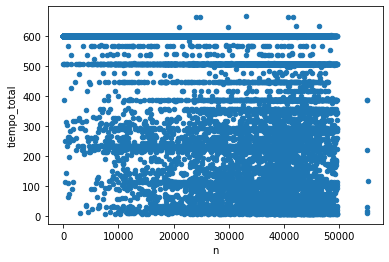

In [ ]:
df_time_agg[df_time_agg['n']<60_000].plot.scatter(x='n',y='tiempo_total')

* No visible relation

# Número

## Total working people by servei territorial

### At inici, first month

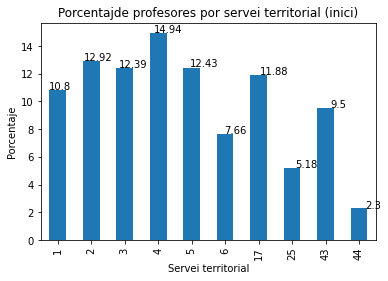

In [ ]:
df_inici_by_count=df_inici.groupby('st').count()/len(df_inici)*100

ax =df_inici_by_count['k'].plot(kind = 'bar', title = 'Porcentajde profesores por servei territorial (inici)', ylabel = 'Porcentaje', xlabel = 'Servei territorial')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.05, p.get_height() * 1.005))

### Two months later

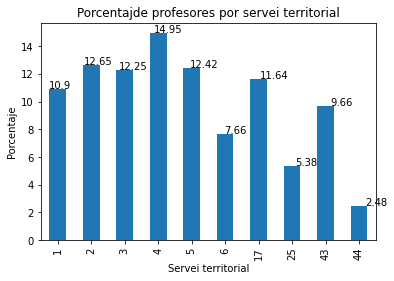

In [ ]:
df_total_by_count=df_total.groupby('st').count()/len(df_total)*100

ax =df_total_by_count['k'].plot(kind = 'bar', title = 'Porcentajde profesores por servei territorial', ylabel = 'Porcentaje', xlabel = 'Servei territorial')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.05, p.get_height() * 1.005))

### Preliminary conclusions

* The percentage of people per servi territorial keeps roughtly constant trough the time period explored
* Servei territorial 4 is the one who need more "interins".
* Serveis territorials 2, 3, 5 and 17 need roughly the same amount of people and are worth to consider.

## How many people before me.

In [ ]:
# order number to study
numbers_to_discard=35_000
order_number=45238

In [ ]:
# As we can see above all the people with a number  higher than 40000 seems to be working. There can be many reason for a number 
# to not appears on the list that we can not account for. To be in the safe side the numbers to discard will be above 35000 

list_of_working_numebers=list(zip(df_total['n'].to_list(),df_total['st'].to_list()))
list_of_numebers=df_total['n'].to_list()

numeros_superiores_discard=0

for i in tqdm(range(1,numbers_to_discard+1)):
    if i not in list_of_numebers:
        numeros_superiores_discard+=1

print(numeros_superiores_discard)

100%|██████████| 35000/35000 [00:08<00:00, 3943.36it/s]

3327


In [ ]:
# I create a list of tuples to iterate over. (number,servei territorial)

list_of_working_numebers=list(zip(df_total['n'].to_list(),df_total['st'].to_list()))
list_of_numebers=df_total['n'].to_list()

numeros_superiores=0

for i in tqdm(range(1,order_number+1)):
    if i not in list_of_numebers:
        numeros_superiores+=1





100%|██████████| 45238/45238 [00:14<00:00, 3174.28it/s]


In [ ]:
(numeros_superiores-numeros_superiores_discard)*0.12

342.36

### Number distribution by specilization

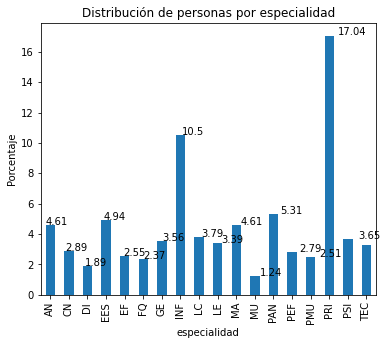

In [ ]:


df_esp_total=df_total.groupby('k')['k'].count()/len(df_total)*100

ax=df_esp_total[df_esp_total>1].plot(kind='bar', title='Distribución de personas por especialidad', ylabel='Porcentaje',xlabel='especialidad', figsize=(6, 5))

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.05, p.get_height() * 1.005))

In [ ]:
numeros_superiores_discard

3327

In [ ]:
numeros_superiores

6180

In [ ]:
# 0.12 and 0.04 are % stracted from the plots above to stimate how many is before a particular number
# 0.12 Is the % of teachers in the servei territorial 2
# 0.4 is the % of techers for a specific spciality/topic in the servei territorial 2
(numeros_superiores-numeros_superiores_discard)*0.12*0.04

13.694400000000002

### Preliminary overall conclusions

* The proportions keep roughtly constant trough different aggrupation settings
* Our friend has about 13/26 potetial candidates before her (depending on considerations)

## How long can it take before i get hired?

In [ ]:
df_date_k=df_total[df_total['st']==2].groupby(['data','k']).count()['n'].reset_index()

In [ ]:
# It is necessary t odiscard the first period, since it is not comparable to the rest of the year.
np.mean(df_date_k[df_date_k['k']=='GE']['n'].tolist()[8:])

1.4285714285714286

In [ ]:
# There are 3 "nomenaments" per week and 1.5 nomenaments in average for the speciality/topic GE at the "servei territorial" 2

print('She has to plan for a period of about {} weeks without interin work. If I do not discard any number then se has to plan for {} weeks'\
.format(round(12/(1.5*3),0),round((numeros_superiores)*0.14*0.0356/(1.5*3),0)))

She has to plan for a period of about 3.0 weeks without interin work. If I do not discard any number then se has to plan for 6.0 weeks
